In [1]:
# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

import torch
torch.hub.set_dir('/scratch/toponav/indoor-topo-loc/checkpoints/torchhub')
print(torch.hub.get_dir())  

/home2/rjayanti/workdirs/rjayanti/kp2seg-evals
/scratch/toponav/indoor-topo-loc/checkpoints/torchhub


In [2]:
from pathlib import Path
from configs.default import cfg
# from src.utils.viz_utils import load_image, plot_images

eval_spp_config = 'configs/config_eval_spp_resz.yaml'
cfg.merge_from_file(eval_spp_config)

CURR_SCENE='e8e81396b6'
FRAME0_NAME, FRAME1_NAME = 'DSC05283', 'DSC05214'

dslr_path = Path(cfg["DATASET"]["DATA_ROOT"])
segdata_orig_path = Path(cfg["DATASET"]["SEGDATA_ROOT"])

# load frames
frame0_path = dslr_path / CURR_SCENE / f"{FRAME0_NAME}.JPG"
frame1_path = dslr_path / CURR_SCENE / f"{FRAME1_NAME}.JPG"

frame0_segdata_path = segdata_orig_path / CURR_SCENE / f"{FRAME0_NAME}.JPG.pkl"
frame1_segdata_path = segdata_orig_path / CURR_SCENE / f"{FRAME1_NAME}.JPG.pkl"

In [3]:
from src.datasets.paired_data_interface import PairedImageMaskDataset
from torch.utils.data import DataLoader

img_paths0 = [frame0_path]
img_paths1 = [frame1_path]
mask_paths0 = [frame0_segdata_path]
mask_paths1 = [frame1_segdata_path]

dataset = PairedImageMaskDataset(
    img_paths0=[frame0_path],
    img_paths1=[frame1_path],
    mask_paths0=[frame0_segdata_path],
    mask_paths1=[frame1_segdata_path],
)

# NOTE: Currently dataset only supports batch size of 1 - to allow for variable number of masks
loader = DataLoader(dataset, batch_size=1)

/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/matching/third_party/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading...
From (original): https://drive.google.com/uc?id=1gk97V4IROnR1Nprq10W9NCFUv2mxXR_-
From (redirected)

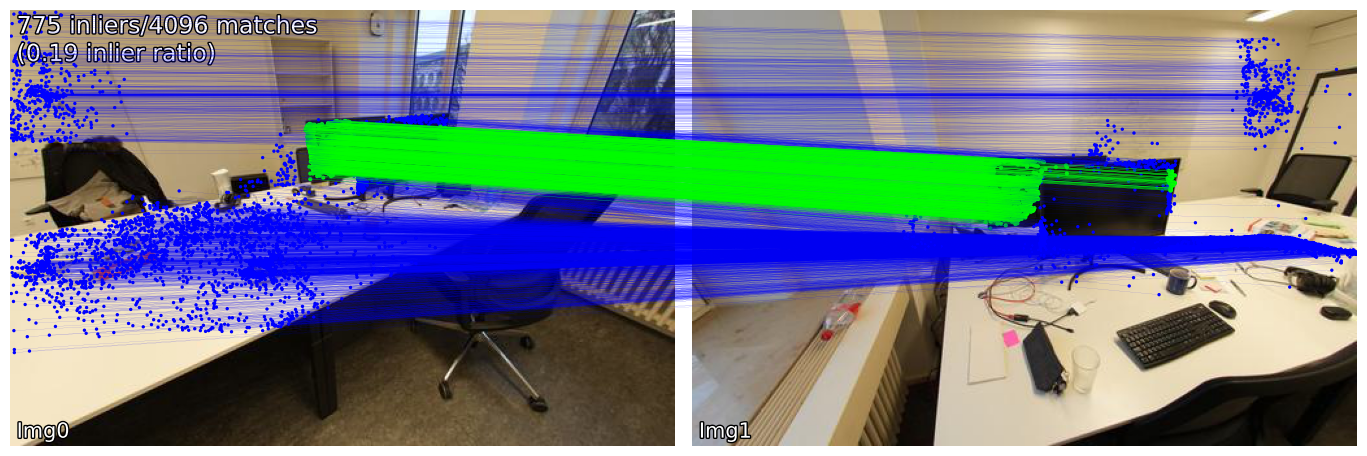

In [ ]:
from matching import get_matcher
from matching.viz import plot_matches

device = 'cuda'  # 'cpu'
matcher = get_matcher('gim-dkm', device=device, max_num_keypoints=4096)

batch = next(iter(loader))
img0_path, img1_path = batch['img0_path'], batch['img1_path']
masks0, masks1 = batch['masks0'], batch['masks1']

img0 = matcher.load_image(str(img0_path[0]))
img1 = matcher.load_image(str(img1_path[0]))

result = matcher(img0, img1)

# num_inliers, inlier_kpts0, inlier_kpts1 = result['num_inliers'], result['inlier_kpts0'], result['inlier_kpts1']
# # result.keys() = ['num_inliers', 'H', 'all_kpts0', 'all_kpts1', 'all_desc0', 'all_desc1', 'matched_kpts0', 'matched_kpts1', 'inlier_kpts0', 'inlier_kpts1']
# plot_matches(img0, img1, result, show_all_kpts=False)

In [ ]:
import torch
import numpy as np
import json
from collections import defaultdict

def compute_vote_matrix(matched_kpts0, matched_kpts1, masks0, masks1):
    K = matched_kpts0.shape[0]
    M, H, W = masks0.shape
    N = masks1.shape[0]

    x0 = matched_kpts0[:, 0].long().clamp(0, W - 1)
    y0 = matched_kpts0[:, 1].long().clamp(0, H - 1)
    x1 = matched_kpts1[:, 0].long().clamp(0, W - 1)
    y1 = matched_kpts1[:, 1].long().clamp(0, H - 1)

    src_mask_ids = masks0[:, y0, x0].T  # (K, M)
    tgt_mask_ids = masks1[:, y1, x1].T  # (K, N)

    valid = src_mask_ids.any(dim=1) & tgt_mask_ids.any(dim=1)
    src_idx = src_mask_ids[valid].argmax(dim=1)
    tgt_idx = tgt_mask_ids[valid].argmax(dim=1)

    votes = torch.zeros((M, N), dtype=torch.int32)
    for i, j in zip(src_idx.tolist(), tgt_idx.tolist()):
        votes[i, j] += 1
    return votes

def get_pred_assignment(votes):
    pred = votes.argmax(dim=1)
    pred[votes.sum(dim=1) == 0] = -1
    return pred

def compute_iou(pred_assignment, gt_assignment):
    M, N = gt_assignment.shape
    gt_idx = gt_assignment.argmax(dim=1)
    has_gt = gt_assignment.sum(dim=1) > 0

    ious = []
    for i in range(M):
        if not has_gt[i] and pred_assignment[i] == -1:
            ious.append(1.0)
        elif has_gt[i] and pred_assignment[i] == gt_idx[i]:
            ious.append(1.0)
        else:
            ious.append(0.0)
    return float(np.mean(ious)) if ious else 0.0

def evaluate_all(loader, matcher, output_json_path):
    results = defaultdict(dict)

    for batch in loader:
        scene_id = batch["scene_id"][0]
        frame0 = batch["frame0_name"][0]
        frame1 = batch["frame1_name"][0]
        key = f"{frame0}_{frame1}"

        img0 = matcher.load_image(str(batch["img0_path"][0]))
        img1 = matcher.load_image(str(batch["img1_path"][0]))
        result = matcher(img0, img1)

        kpts0 = result["matched_kpts0"]
        kpts1 = result["matched_kpts1"]
        masks0 = batch["masks0"][0].bool()
        masks1 = batch["masks1"][0].bool()
        gt_assignment = batch["gt_assignment"][0].int()

        votes = compute_vote_matrix(kpts0, kpts1, masks0, masks1)
        pred_assignment = get_pred_assignment(votes)
        avg_iou = compute_iou(pred_assignment, gt_assignment)

        results[scene_id][key] = avg_iou

    with open(output_json_path, "w") as f:
        json.dump(results, f, indent=2)
    return results